In [1]:
import numpy as np
import argparse
import sys
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import  ActivityRegularization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.keras import utils as np_utils

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
#print(device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

gpus = tf.config.experimental.list_physical_devices('GPU') 
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
# Settings -----------

SOURCE_IMG_WIDTH = 299
SOURCE_IMG_HEIGHT = SOURCE_IMG_WIDTH

DATA_PATH = 'Data' +str(SOURCE_IMG_WIDTH)+ '\\'
# Settings -----------

# Fix the random seed for reproducibility
seed = 7
np.random.seed(seed)

Default GPU Device:  /device:GPU:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Data Generators

# Data augmentation should only apply to the training set (If any)
train_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))

valid_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest")

test_datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.0, width_shift_range=0.0, 
                                   height_shift_range=0.0, rescale=1.0/255.0, #preprocessing_function=preprocess_input,
                                   shear_range=0.00, horizontal_flip=False, fill_mode="nearest",
                                   brightness_range=(0.6,1.4))


train_generator = train_datagen.flow_from_directory(
    directory=DATA_PATH + 'train\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb", #rgb
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory=DATA_PATH + 'val\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=DATA_PATH + 'test\\',
    target_size=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    #save_to_dir="preview\\",
    #save_prefix ="TEST_",
    #save_format="tif",
    seed=42
)

np.save('labels', train_generator.class_indices)

Found 10335 images belonging to 33 classes.
Found 5163 images belonging to 33 classes.
Found 5172 images belonging to 33 classes.


In [4]:
# Model defination
base_model = InceptionV3(include_top=False, input_shape=(SOURCE_IMG_HEIGHT, SOURCE_IMG_WIDTH, 3), weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
#model.add(ActivityRegularization(l2=0.01, l1=0.01))
#model.add(Dropout(.2))
model.add(Dense(33, activation='softmax', name='outputLayer'))

model.summary()

#for layer in model.layers:
#    print(layer.name, layer.trainable)

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
outputLayer (Dense)          (None, 33)                33825     
Total params: 23,934,785
Trainable params: 2,132,001
Non-trainable params: 21,802,784
_________________________________________________________________


In [5]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta = 0.001)
mc_top = ModelCheckpoint('inc_best_top_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mc = ModelCheckpoint('inc_best_checkpoint.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, min_delta=0.001, verbose=1)

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

In [6]:
# train the top 
EPOCHS = 10

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc_top, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  19:05:38
Epoch 1/10
322/322 [==============================] - ETA: 0s - loss: 10.7224 - accuracy: 0.6614
Epoch 00001: val_accuracy improved from -inf to 0.66168, saving model to best_top_checkpoint.h5
322/322 [==============================] - 106s 328ms/step - loss: 10.7224 - accuracy: 0.6614 - val_loss: 7.2599 - val_accuracy: 0.6617
Epoch 2/10
322/322 [==============================] - ETA: 0s - loss: 5.1350 - accuracy: 0.8042
Epoch 00002: val_accuracy improved from 0.66168 to 0.72224, saving model to best_top_checkpoint.h5
322/322 [==============================] - 50s 155ms/step - loss: 5.1350 - accuracy: 0.8042 - val_loss: 4.0081 - val_accuracy: 0.7222
Epoch 3/10
322/322 [==============================] - ETA: 0s - loss: 2.9565 - accuracy: 0.8275
Epoch 00003: val_accuracy improved from 0.72224 to 0.72283, saving model to best_top_checkpoint.h5
322/322 [==============================] - 50s 155ms/step - loss: 2.9565 - accuracy: 0.8275 - val_loss: 2.6152 - val

In [7]:
model.load_weights("inc_best_top_checkpoint.h5")

# 94% accuracy
for layer in model.layers:
    if(layer.name=="inception_v3"):
        layer.trainable = True
        for ly in layer.layers[:172]:
           ly.trainable = False
        for ly in layer.layers[172:]:
           ly.trainable = True
    else:
        layer.trainable = True

'''
# Debug
for layer in model.layers:
    if(layer.name=="inception_v3"):
        for ly in layer.layers:
            print(ly.name, ly.trainable)
    print(layer.name, layer.trainable)
'''

# Compile the model
model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.SGD(),
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=optimizers.RMSprop(lr=1e-3),
              #optimizer=optimizers.Adadelta(lr=1),
              #optimizer=optimizers.Nadam(lr=2e-4),              
              #optimizer=optimizers.Adamax(lr=2e-4),              
              metrics=['accuracy'])

In [8]:
EPOCHS = 200

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Start Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

history_pre = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, callbacks=[tensorboard_callback, es, mc, lr]
)

print("End Training Time: ", datetime.datetime.now().strftime("%H:%M:%S"))

Start Training Time:  19:15:00
Epoch 1/200
322/322 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.8289
Epoch 00001: val_accuracy improved from -inf to 0.81192, saving model to best_checkpoint.h5
322/322 [==============================] - 59s 185ms/step - loss: 1.1590 - accuracy: 0.8289 - val_loss: 1.0394 - val_accuracy: 0.8119
Epoch 2/200
322/322 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.9114
Epoch 00002: val_accuracy improved from 0.81192 to 0.85384, saving model to best_checkpoint.h5
322/322 [==============================] - 51s 158ms/step - loss: 0.6273 - accuracy: 0.9114 - val_loss: 0.7035 - val_accuracy: 0.8538
Epoch 3/200
322/322 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.9402
Epoch 00003: val_accuracy improved from 0.85384 to 0.86316, saving model to best_checkpoint.h5
322/322 [==============================] - 51s 158ms/step - loss: 0.3997 - accuracy: 0.9402 - val_loss: 0.6202 - val_accuracy: 0

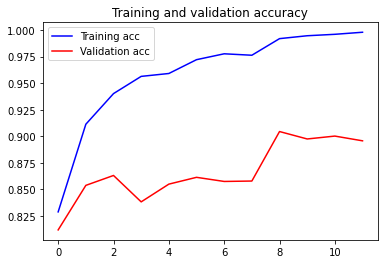

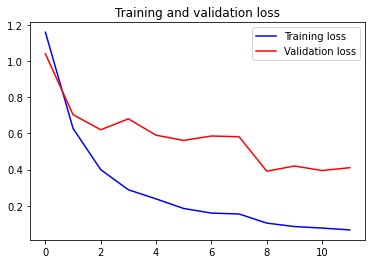

In [9]:
# Plot the accuracy and loss curves
acc = history_pre.history['accuracy']
val_acc = history_pre.history['val_accuracy']
loss = history_pre.history['loss']
val_loss = history_pre.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model = models.load_model('inc_best_checkpoint.h5')

if os.path.isfile('labels.npy'):
    class_indices = np.load('labels.npy',allow_pickle=True).item()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
scores = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST) 
print("Test Loss =", scores[0], "Test Accuracy =", scores[1])

Test Loss = 0.27432751655578613 Test Accuracy = 0.936194896697998


[0]
['Acinetobacter.baumanii']


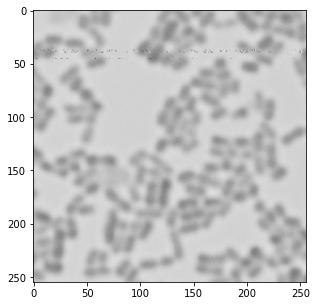

In [11]:
# Manual test
img = image.load_img('data\\test\\Acinetobacter.baumanii\\Acinetobacter.baumanii_0004_30.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 


[13]
['Lactobacillus.gasseri']


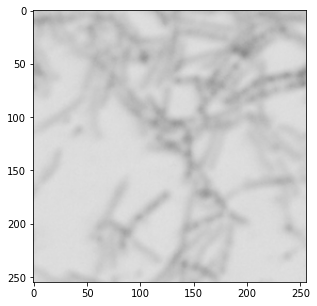

In [12]:
img = image.load_img('data\\test\\Lactobacillus.gasseri\\Lactobacillus.gasseri_0004_11.tif')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(img_tensor[0]/255)
#img_tensor = preprocess_input(img_tensor)
img_tensor /= 255.

#cls = model.predict(img_tensor)
#print(cls)

cls = model.predict_classes(img_tensor)
print(cls)
label_map = class_indices
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in cls] 
print(predictions) 


Confusion Matrix


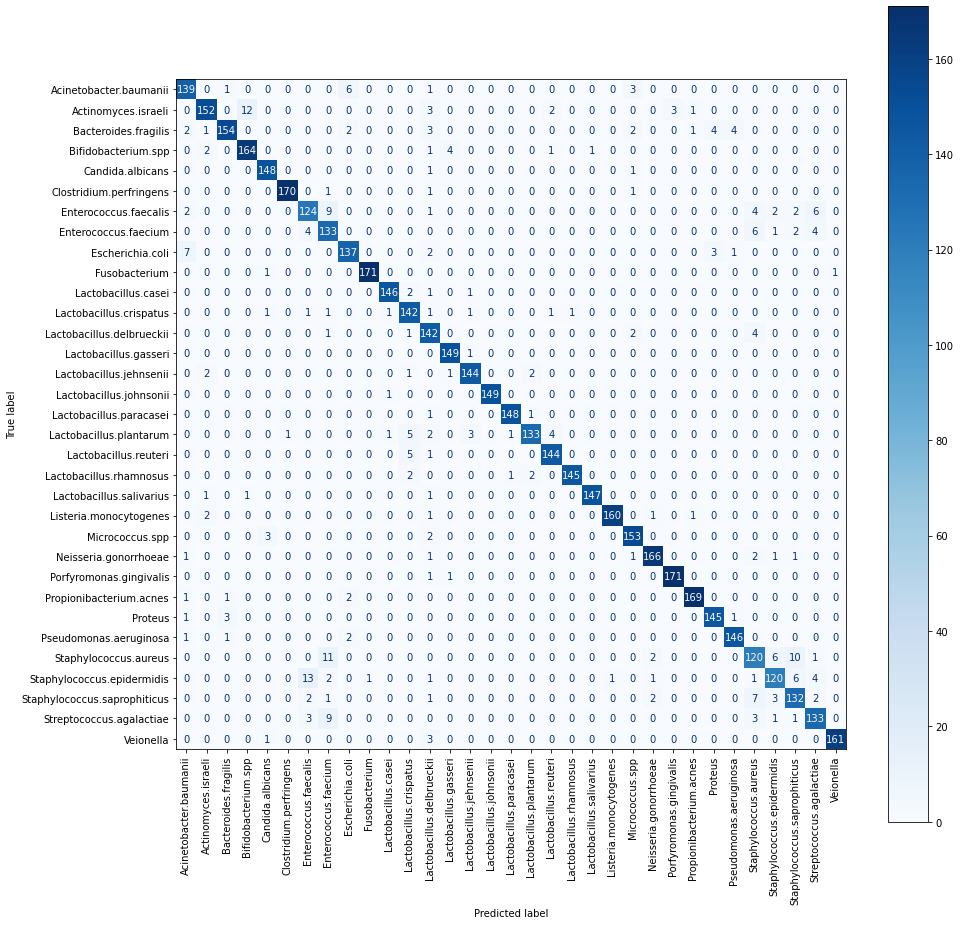

Classification Report
                              precision    recall  f1-score   support

      Acinetobacter.baumanii       0.90      0.93      0.91       150
         Actinomyces.israeli       0.95      0.88      0.91       173
        Bacteroides.fragilis       0.96      0.89      0.92       173
         Bifidobacterium.spp       0.93      0.95      0.94       173
            Candida.albicans       0.96      0.99      0.97       150
     Clostridium.perfringens       0.99      0.98      0.99       173
       Enterococcus.faecalis       0.84      0.83      0.84       150
        Enterococcus.faecium       0.79      0.89      0.84       150
            Escherichia.coli       0.92      0.91      0.92       150
               Fusobacterium       0.99      0.99      0.99       173
         Lactobacillus.casei       0.98      0.97      0.98       150
     Lactobacillus.crispatus       0.90      0.95      0.92       150
   Lactobacillus.delbrueckii       0.83      0.95      0.88       1

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#model = models.load_model('best_checkpoint.h5')
#class_indices = np.load('labels.npy',allow_pickle=True).item()

#np.set_printoptions(threshold=np.inf) # to see the full confusion matrix
np.set_printoptions(threshold=1000) #

#Confusion Matrix and Classification Report

Y_pred = model.predict_generator(test_generator,test_generator.n)
y_pred = np.argmax(Y_pred, axis=1)
target_names = class_indices

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.rcParams["figure.figsize"] = (15,15)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))